## Это пятая лаба по питону.


In [120]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import glob
import random

learning_rate = 0.001
batch_size = 10
epochs = 10

#устанавливаем зерно и случайное значение
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

1-2. Загрузка и разделение набора данных на выборки.

In [121]:
train_path = 'E:\dataset\\train'
test_path = 'E:\dataset\\test'
val_path = 'E:\dataset\\val'

df = pd.read_csv('dataset.csv', sep = ' ')
df = df.rename(columns={'Absolute_way': 'absolute_way'})
df = df.rename(columns={'Class': 'class_img'})

if not os.path.isdir(train_path):
    os.mkdir(train_path)

if not os.path.isdir(test_path):
    os.mkdir(test_path)

if not os.path.isdir(val_path):
    os.mkdir(val_path)

def load_train(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    '''
    Загружает i-ую картинку из датафрейма по заданному пути path
    Ключевые аргументы:
        df(pd.core.frame.DataFrame): датафрейм с картинками 
        path(str): путь загрузки картинок
        i(int): номер картинки
    '''
    image_path = df.absolute_way[i]
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{df.class_img[i]}.{i}.jpg'), image)

def load_test(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    '''
    Загружает i-ую картинку из датафрейма по заданному пути path
    Ключевые аргументы:
        df(pd.core.frame.DataFrame): датафрейм с картинками 
        path(str): путь загрузки картинок
        i(int): номер картинки
    '''
    image_path = df.absolute_way[i]
    image = cv2.imread(image_path)
    if i - 840 > 104: 
        i = i - 1785
    else:
        i = i -840
    cv2.imwrite(os.path.join(path, f'{i}.jpg'), image)


for i in range(840):
    load_train(df, train_path, i)

for i in range(840, 945):
    load_test(df, test_path, i)

for i in range(945, 1050):
    load_train(df, val_path, i)

for i in range(1050, 1890):
    load_train(df, train_path, i)

for i in range(1890, 1995):
    load_test(df, test_path, i)

for i in range(1995, 2100):
    load_train(df, val_path, i)
    

train_list = glob.glob(os.path.join(train_path,'*.jpg'))
test_list = glob.glob(os.path.join(test_path, '*.jpg'))

train_list, val_list = train_test_split(train_list, test_size=0.1)



Проверка набора данных.

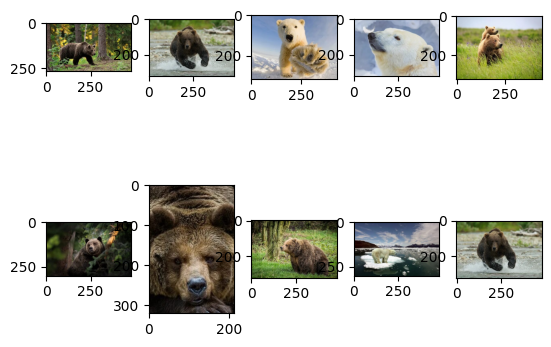

In [161]:
random_idx = np.random.randint(1,200,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = cv2.imread(train_list[idx])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    i+=1

plt.show()

3. Модель свёрточной нейронной сети.

In [162]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

model = ConvNet().to(device)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


4. Пайплайн предобработки данных.

In [163]:
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

Предобработка данных.

In [164]:
from PIL import Image

class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('\\')[-1].split('.')[0]
        if label == 'polarbears':
            label = 1
        elif label == 'brownbears':
            label = 0
            
        return img_transformed,label


train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=val_transforms)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)


5-6. Обучение.

Learning rate: 0.001, Batch size: 10
Epoch : 1, train accuracy : 0.8782892823219299, train loss : 0.31721776723861694
Epoch : 1, val_accuracy : 0.9161764979362488, val_loss : 0.238249272108078
Epoch : 2, train accuracy : 0.9026312828063965, train loss : 0.2525939643383026
Epoch : 2, val_accuracy : 0.9161764979362488, val_loss : 0.22542476654052734
Epoch : 3, train accuracy : 0.9144734740257263, train loss : 0.2240927666425705
Epoch : 3, val_accuracy : 0.9294118285179138, val_loss : 0.17350563406944275
Epoch : 4, train accuracy : 0.9164469838142395, train loss : 0.22278563678264618
Epoch : 4, val_accuracy : 0.9397059082984924, val_loss : 0.21595239639282227
Epoch : 5, train accuracy : 0.9203943014144897, train loss : 0.20227256417274475
Epoch : 5, val_accuracy : 0.9279412031173706, val_loss : 0.20712120831012726
Epoch : 6, train accuracy : 0.9256576299667358, train loss : 0.19825127720832825
Epoch : 6, val_accuracy : 0.9411765336990356, val_loss : 0.17777930200099945
Epoch : 7, train ac

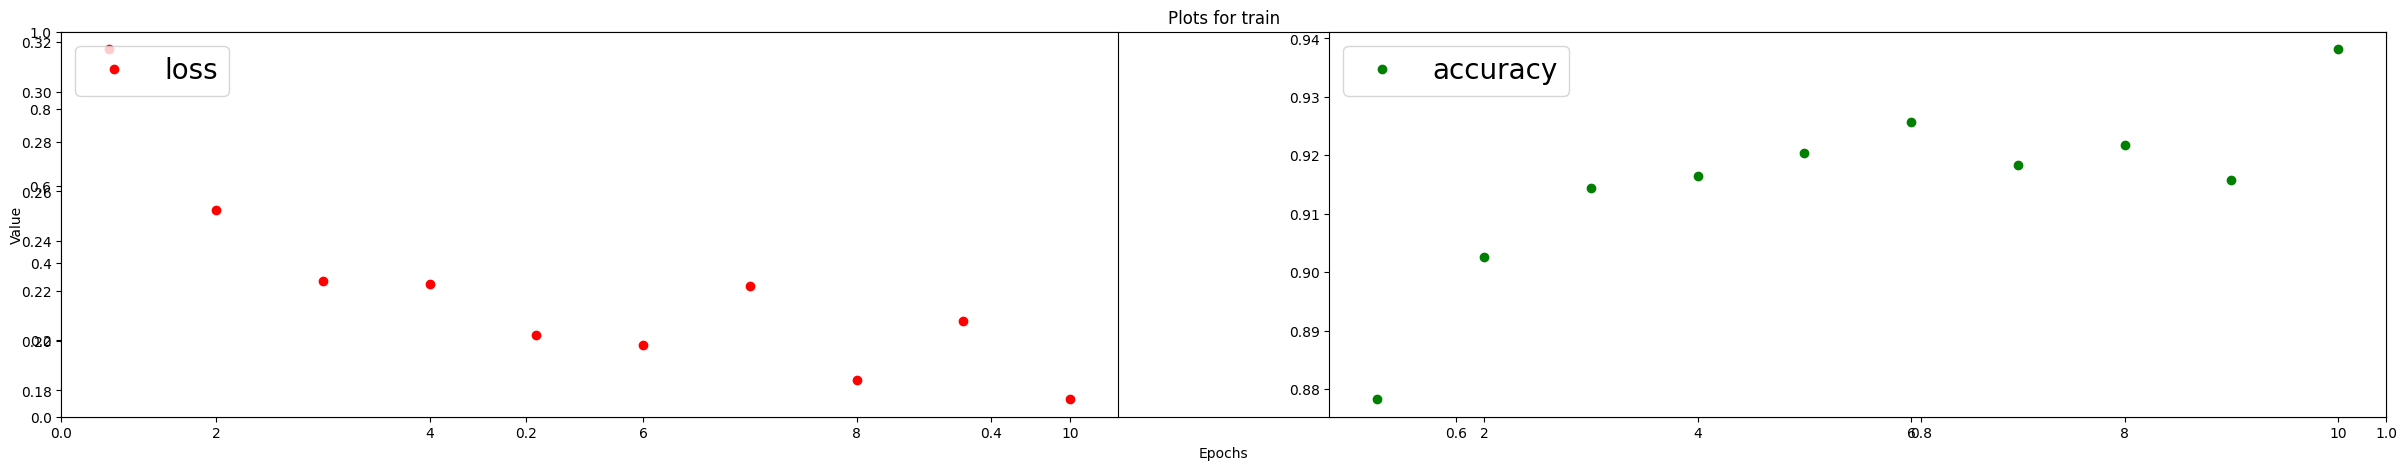

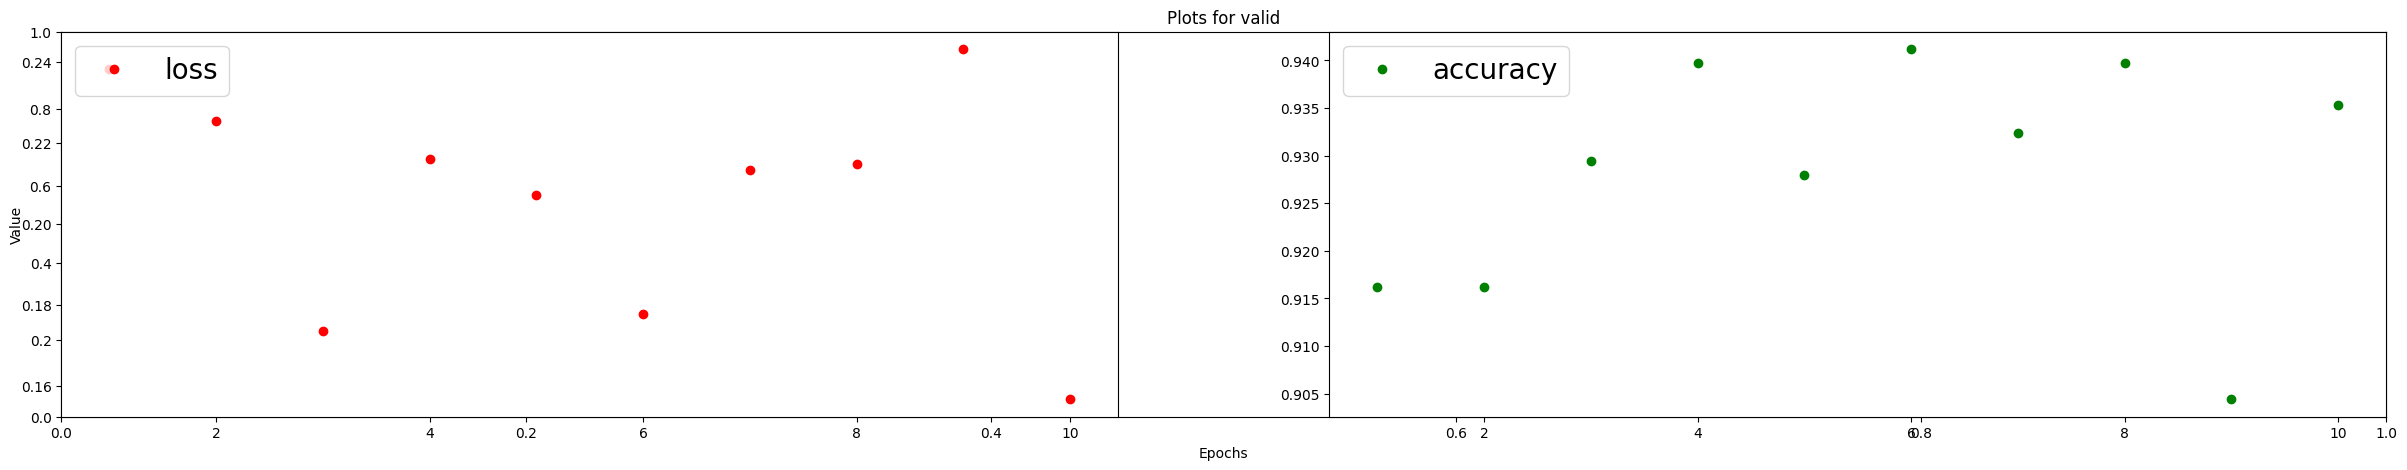

In [165]:
print('Learning rate: 0.001, Batch size: 10')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

epochs = 10
def train_loop (train_loader, val_loader, epochs):
    val_loss_list = []
    val_accuracy_list = []

    loss_list = []
    accuracy_list = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0

        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)
            
            output = model(data)
            loss = criterion(output, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)

        loss_list.append(epoch_loss.item())
        accuracy_list.append(epoch_accuracy.item())

        print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
        
        
        with torch.no_grad():
            epoch_val_accuracy=0
            epoch_val_loss =0

            for data, label in val_loader:
                data = data.to(device)
                label = label.to(device)
                
                val_output = model(data)
                val_loss = criterion(val_output,label)
                
                acc = ((val_output.argmax(dim=1) == label).float().mean())
                epoch_val_accuracy += acc/ len(val_loader)
                epoch_val_loss += val_loss/ len(val_loader)

            
            val_loss_list.append(epoch_val_loss.item())
            val_accuracy_list.append(epoch_val_accuracy.item())
                
            print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))
    

    num_epochs = [i+1 for i in range(epochs)]

    fig = plt.figure(figsize=(30, 5))
    plt.title('Plots for train')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    fig.add_subplot(1,2,1)
    plt.plot(num_epochs, loss_list, 'ro', label = 'loss')
    plt.legend(loc=2, prop={'size': 20}) 
    fig.add_subplot(1,2,2)
    plt.plot(num_epochs, accuracy_list, 'go', label = 'accuracy')
    plt.legend(loc=2, prop={'size': 20}) 

    fig = plt.figure(figsize=(30, 5))
    plt.title('Plots for valid')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    fig.add_subplot(1,2,1)
    plt.plot(num_epochs, val_loss_list, 'ro', label = 'loss')
    plt.legend(loc=2, prop={'size': 20}) 
    fig.add_subplot(1,2,2)
    plt.plot(num_epochs, val_accuracy_list, 'go', label = 'accuracy')
    plt.legend(loc=2, prop={'size': 20}) 

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0005, Batch size: 10
Epoch : 1, train accuracy : 0.9355259537696838, train loss : 0.18124064803123474
Epoch : 1, val_accuracy : 0.9352942109107971, val_loss : 0.13301578164100647
Epoch : 2, train accuracy : 0.9440786838531494, train loss : 0.14908526837825775
Epoch : 2, val_accuracy : 0.9514706134796143, val_loss : 0.15969234704971313
Epoch : 3, train accuracy : 0.9355260729789734, train loss : 0.157972052693367
Epoch : 3, val_accuracy : 0.9411765336990356, val_loss : 0.14267635345458984
Epoch : 4, train accuracy : 0.9519730806350708, train loss : 0.14060060679912567
Epoch : 4, val_accuracy : 0.9823529720306396, val_loss : 0.08913818001747131
Epoch : 5, train accuracy : 0.9578939080238342, train loss : 0.11952978372573853
Epoch : 5, val_accuracy : 0.9705883264541626, val_loss : 0.10756192356348038
Epoch : 6, train accuracy : 0.939473032951355, train loss : 0.15593376755714417
Epoch : 6, val_accuracy : 0.9470587968826294, val_loss : 0.18605577945709229
Epoch : 7, train 

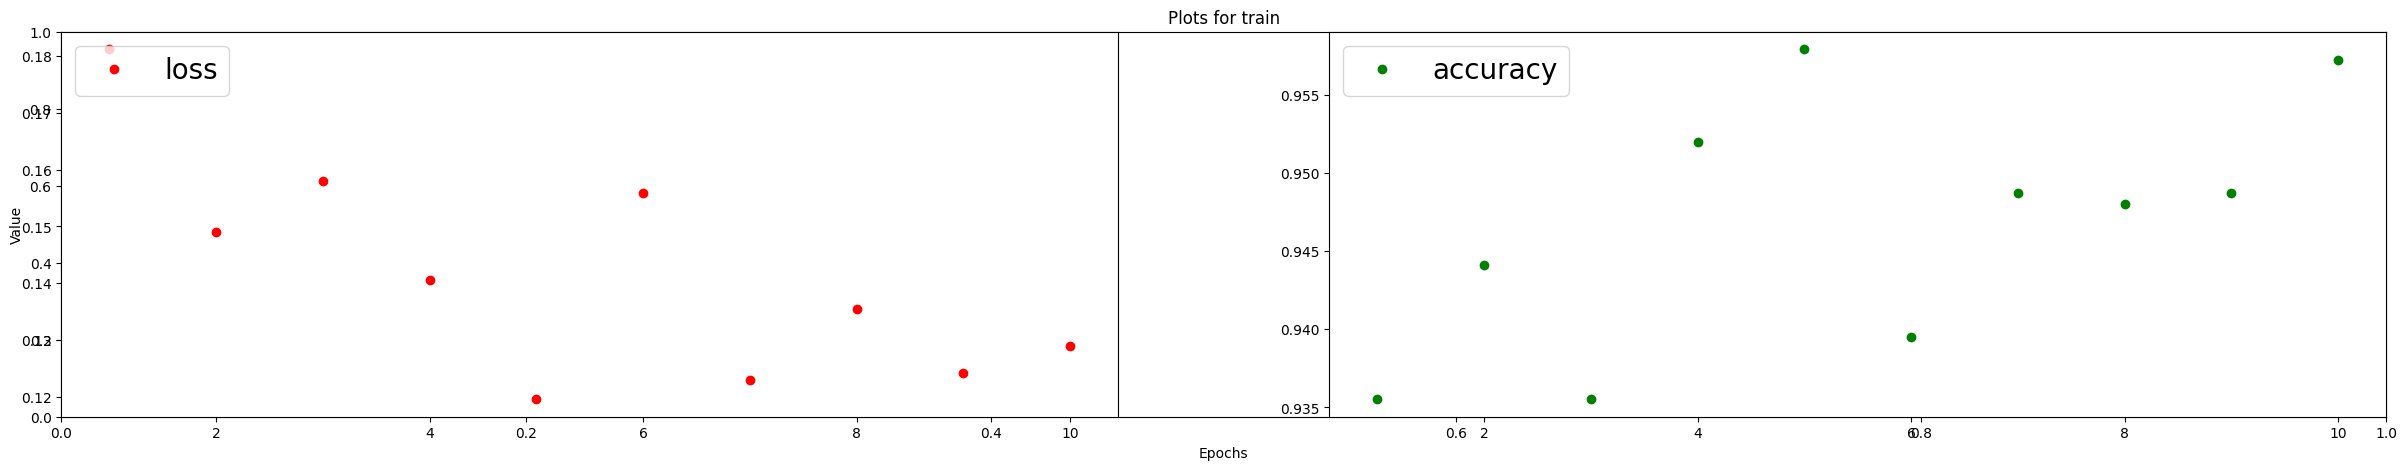

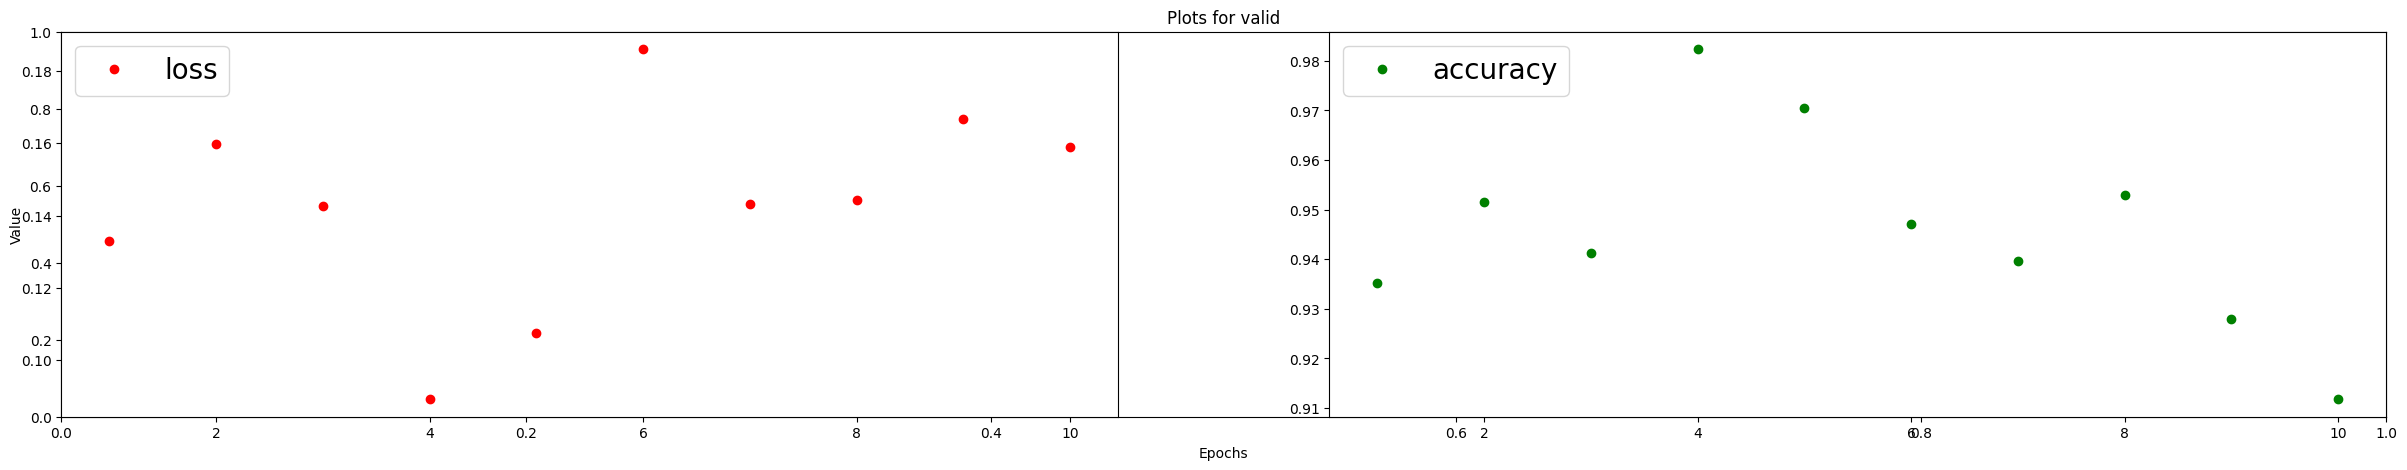

In [127]:
print('Learning rate: 0.0005, Batch size: 10')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 10
Epoch : 1, train accuracy : 0.9552626013755798, train loss : 0.12884129583835602
Epoch : 1, val_accuracy : 0.9573529958724976, val_loss : 0.11726043373346329
Epoch : 2, train accuracy : 0.9532885551452637, train loss : 0.14535917341709137
Epoch : 2, val_accuracy : 0.9705883264541626, val_loss : 0.08487240225076675
Epoch : 3, train accuracy : 0.9532888531684875, train loss : 0.13295912742614746
Epoch : 3, val_accuracy : 0.9823529720306396, val_loss : 0.10066687315702438
Epoch : 4, train accuracy : 0.9401310682296753, train loss : 0.13631592690944672
Epoch : 4, val_accuracy : 0.9514705538749695, val_loss : 0.12709325551986694
Epoch : 5, train accuracy : 0.9486836194992065, train loss : 0.15016700327396393
Epoch : 5, val_accuracy : 0.9647059440612793, val_loss : 0.10022139549255371
Epoch : 6, train accuracy : 0.9552624225616455, train loss : 0.11269745230674744
Epoch : 6, val_accuracy : 0.947058916091919, val_loss : 0.13634054362773895
Epoch : 7, trai

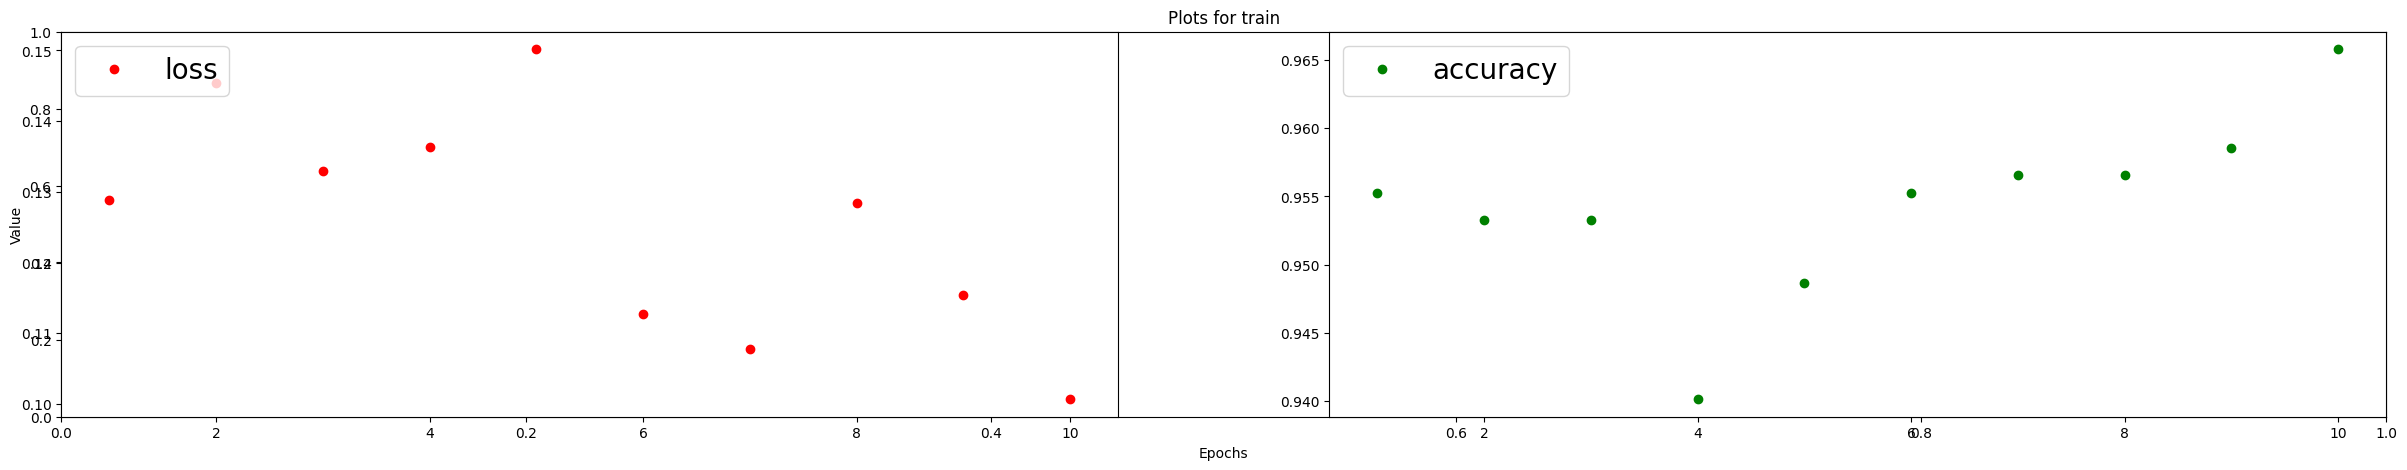

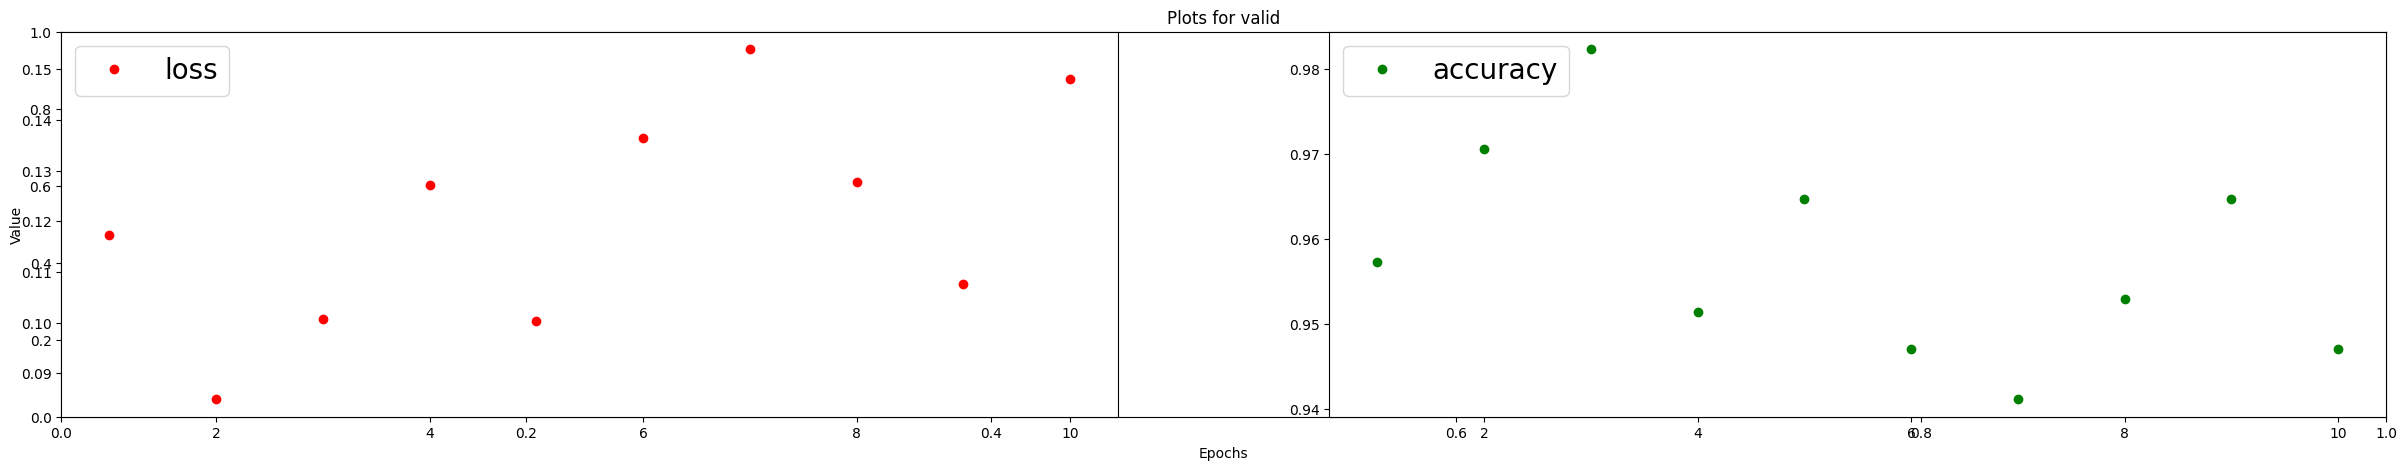

In [128]:
print('Learning rate: 0.0007, Batch size: 10')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.001, Batch size: 20
Epoch : 1, train accuracy : 0.9585525989532471, train loss : 0.1111949235200882
Epoch : 1, val_accuracy : 0.9611110687255859, val_loss : 0.10729101300239563
Epoch : 2, train accuracy : 0.9651315808296204, train loss : 0.09777446836233139
Epoch : 2, val_accuracy : 0.949999988079071, val_loss : 0.14408783614635468
Epoch : 3, train accuracy : 0.9673247337341309, train loss : 0.09410528838634491
Epoch : 3, val_accuracy : 0.9722222089767456, val_loss : 0.10575218498706818
Epoch : 4, train accuracy : 0.9657897353172302, train loss : 0.09446997940540314
Epoch : 4, val_accuracy : 0.9666666388511658, val_loss : 0.09522926062345505
Epoch : 5, train accuracy : 0.9703948497772217, train loss : 0.091358982026577
Epoch : 5, val_accuracy : 0.9555555582046509, val_loss : 0.10968555510044098
Epoch : 6, train accuracy : 0.9708334803581238, train loss : 0.07629695534706116
Epoch : 6, val_accuracy : 0.9472222328186035, val_loss : 0.13450796902179718
Epoch : 7, train ac

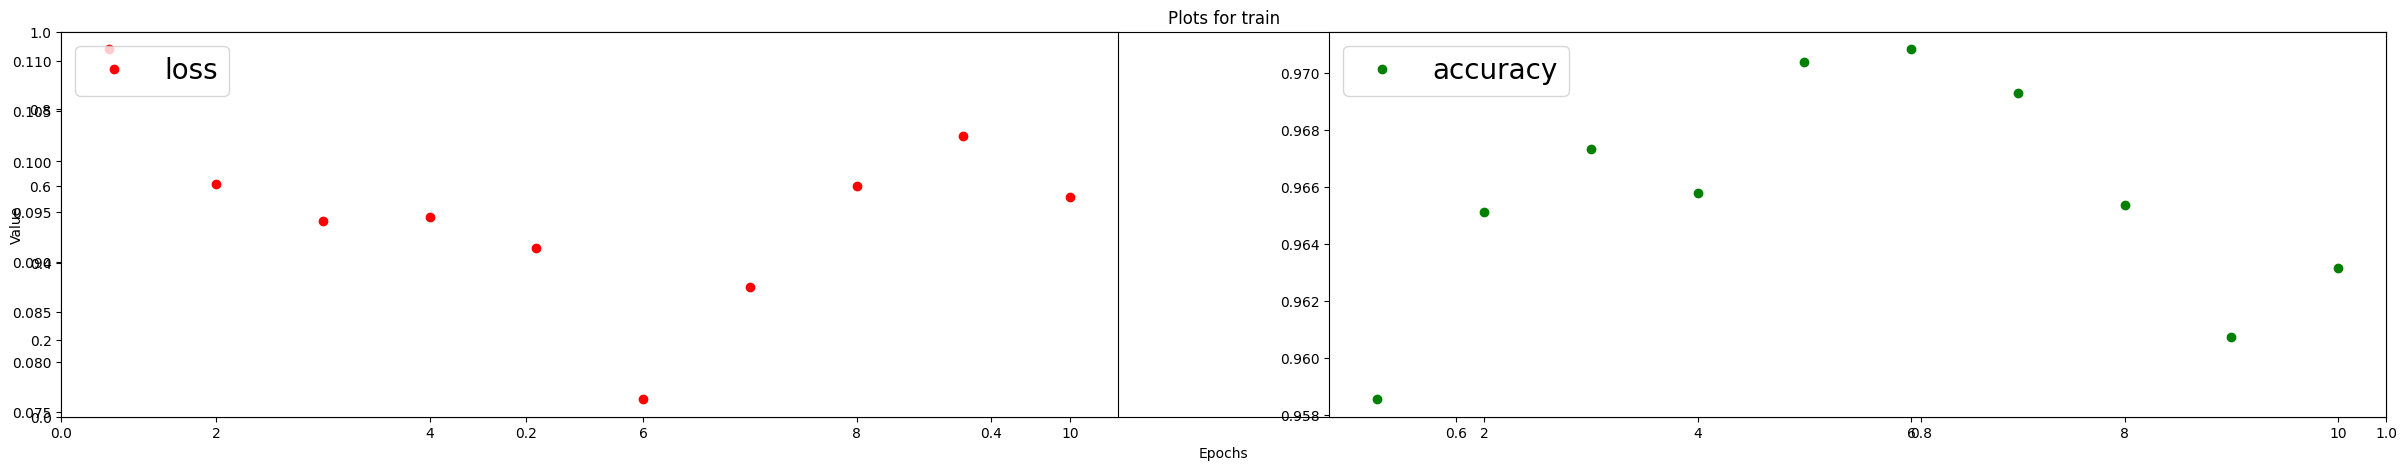

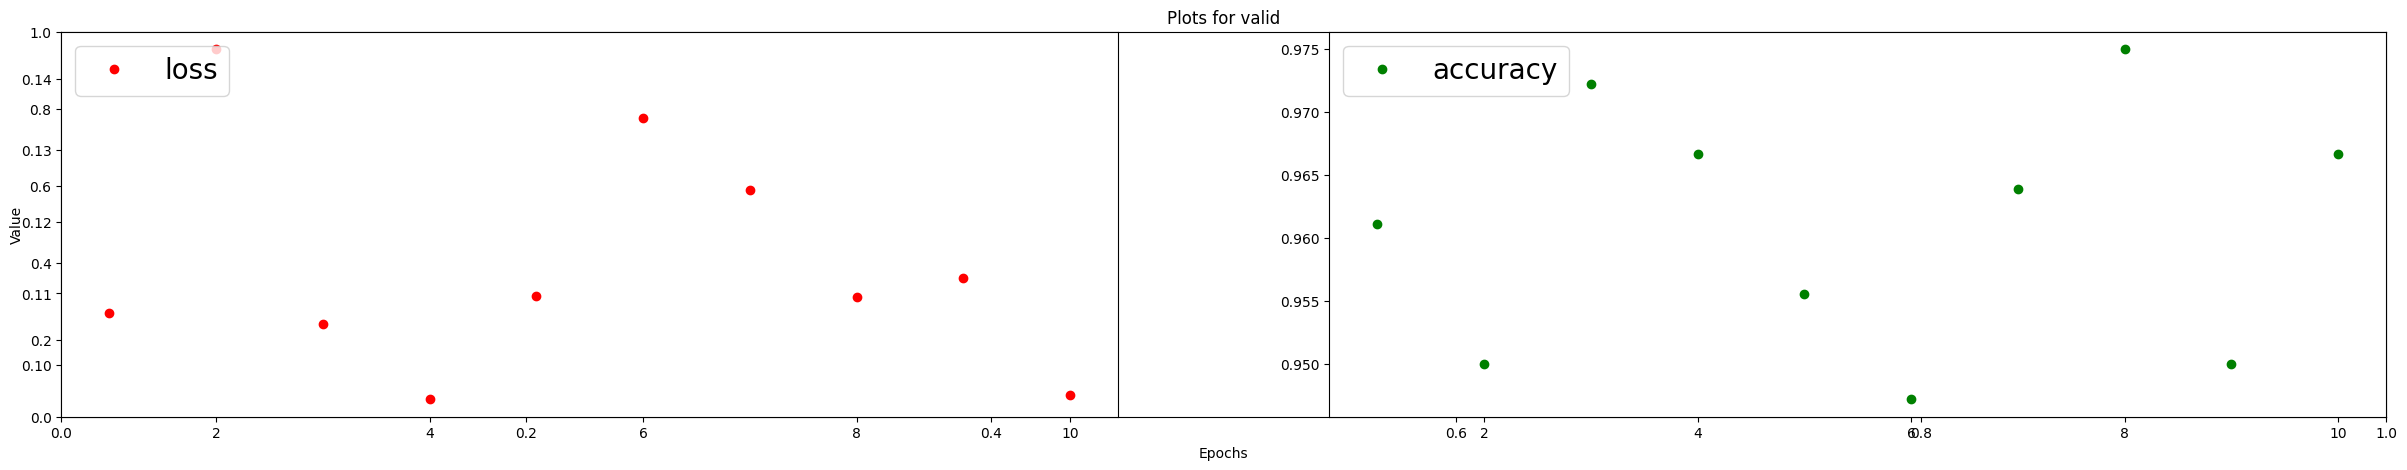

In [129]:
print('Learning rate: 0.001, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=20, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0005, Batch size: 20
Epoch : 1, train accuracy : 0.963596761226654, train loss : 0.09865687787532806
Epoch : 1, val_accuracy : 0.9722222089767456, val_loss : 0.09541928768157959
Epoch : 2, train accuracy : 0.9651317596435547, train loss : 0.08079522103071213
Epoch : 2, val_accuracy : 0.9611111283302307, val_loss : 0.0975753515958786
Epoch : 3, train accuracy : 0.9743422865867615, train loss : 0.07214459031820297
Epoch : 3, val_accuracy : 0.9777777194976807, val_loss : 0.08016301691532135
Epoch : 4, train accuracy : 0.9736842513084412, train loss : 0.07783326506614685
Epoch : 4, val_accuracy : 0.9472221732139587, val_loss : 0.1732501983642578
Epoch : 5, train accuracy : 0.9776317477226257, train loss : 0.066642165184021
Epoch : 5, val_accuracy : 0.9722221493721008, val_loss : 0.07664009183645248
Epoch : 6, train accuracy : 0.978289783000946, train loss : 0.06414006650447845
Epoch : 6, val_accuracy : 0.9777777194976807, val_loss : 0.05785370618104935
Epoch : 7, train acc

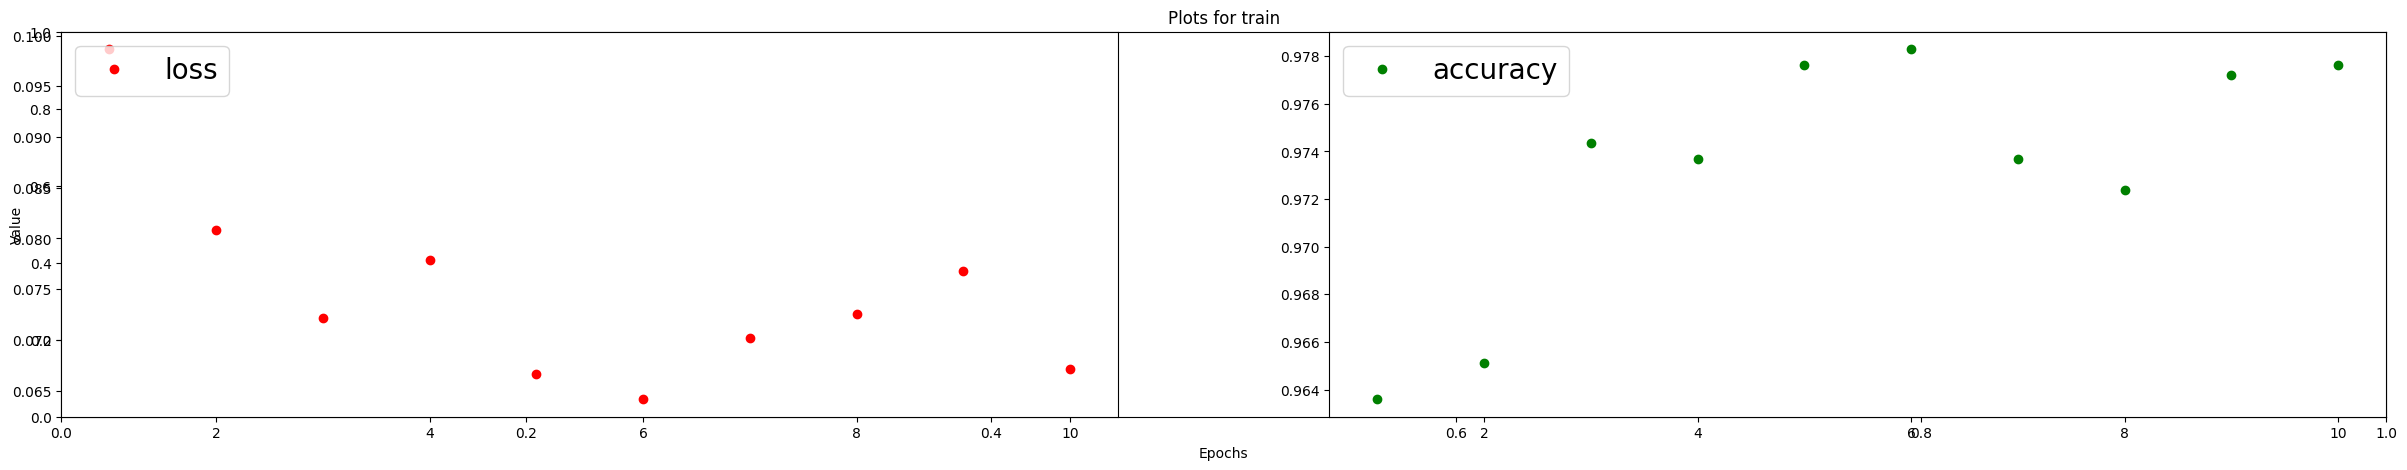

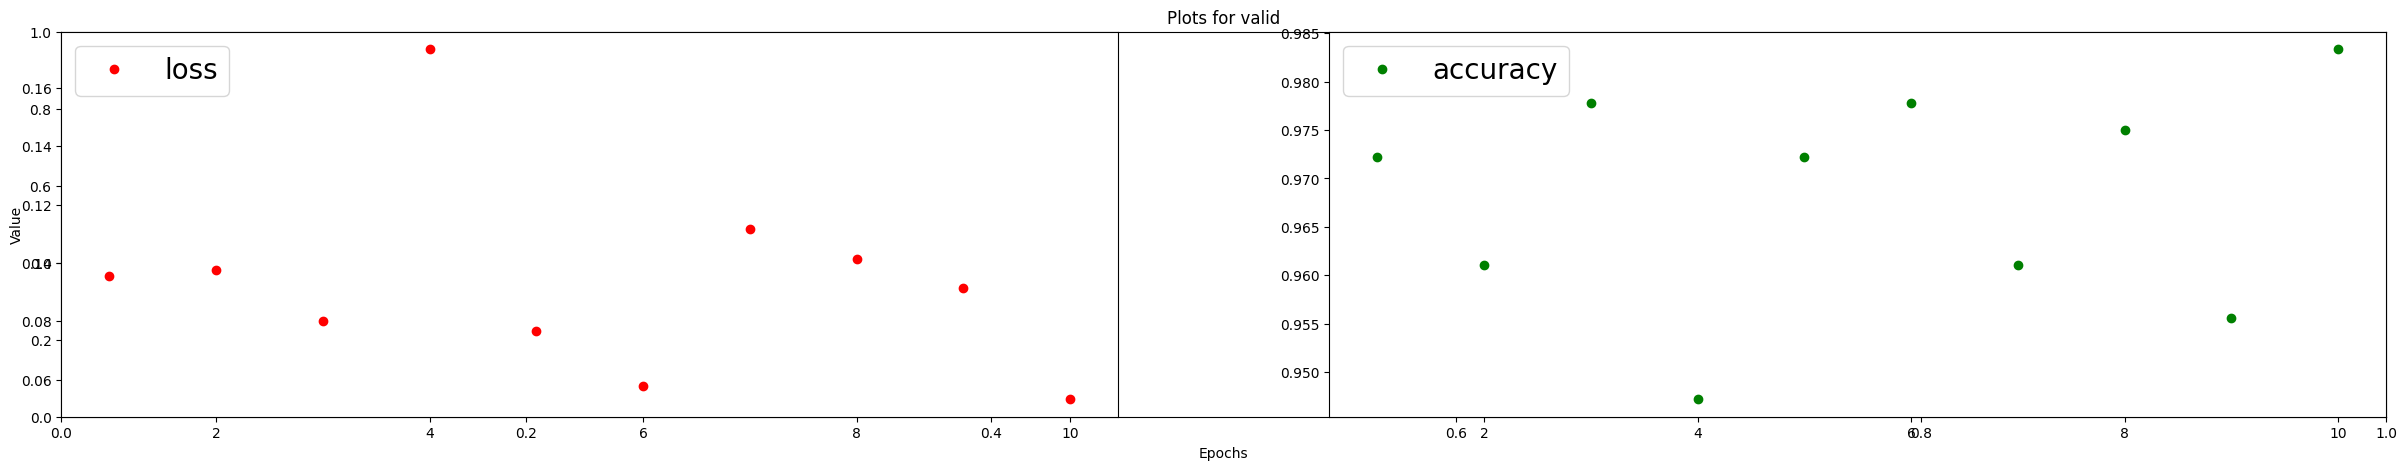

In [130]:
print('Learning rate: 0.0005, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=20, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 20
Epoch : 1, train accuracy : 0.9686405062675476, train loss : 0.08925272524356842
Epoch : 1, val_accuracy : 0.9722222089767456, val_loss : 0.10254490375518799
Epoch : 2, train accuracy : 0.9717106223106384, train loss : 0.0794236809015274
Epoch : 2, val_accuracy : 0.9694443941116333, val_loss : 0.10812029242515564
Epoch : 3, train accuracy : 0.978947639465332, train loss : 0.06888327747583389
Epoch : 3, val_accuracy : 0.9611110687255859, val_loss : 0.08781252801418304
Epoch : 4, train accuracy : 0.9710526466369629, train loss : 0.08101604878902435
Epoch : 4, val_accuracy : 0.9666666388511658, val_loss : 0.06428850442171097
Epoch : 5, train accuracy : 0.9730266332626343, train loss : 0.0762270912528038
Epoch : 5, val_accuracy : 0.9666666388511658, val_loss : 0.11273695528507233
Epoch : 6, train accuracy : 0.9723684787750244, train loss : 0.07988908141851425
Epoch : 6, val_accuracy : 0.9666666984558105, val_loss : 0.12482922524213791
Epoch : 7, train 

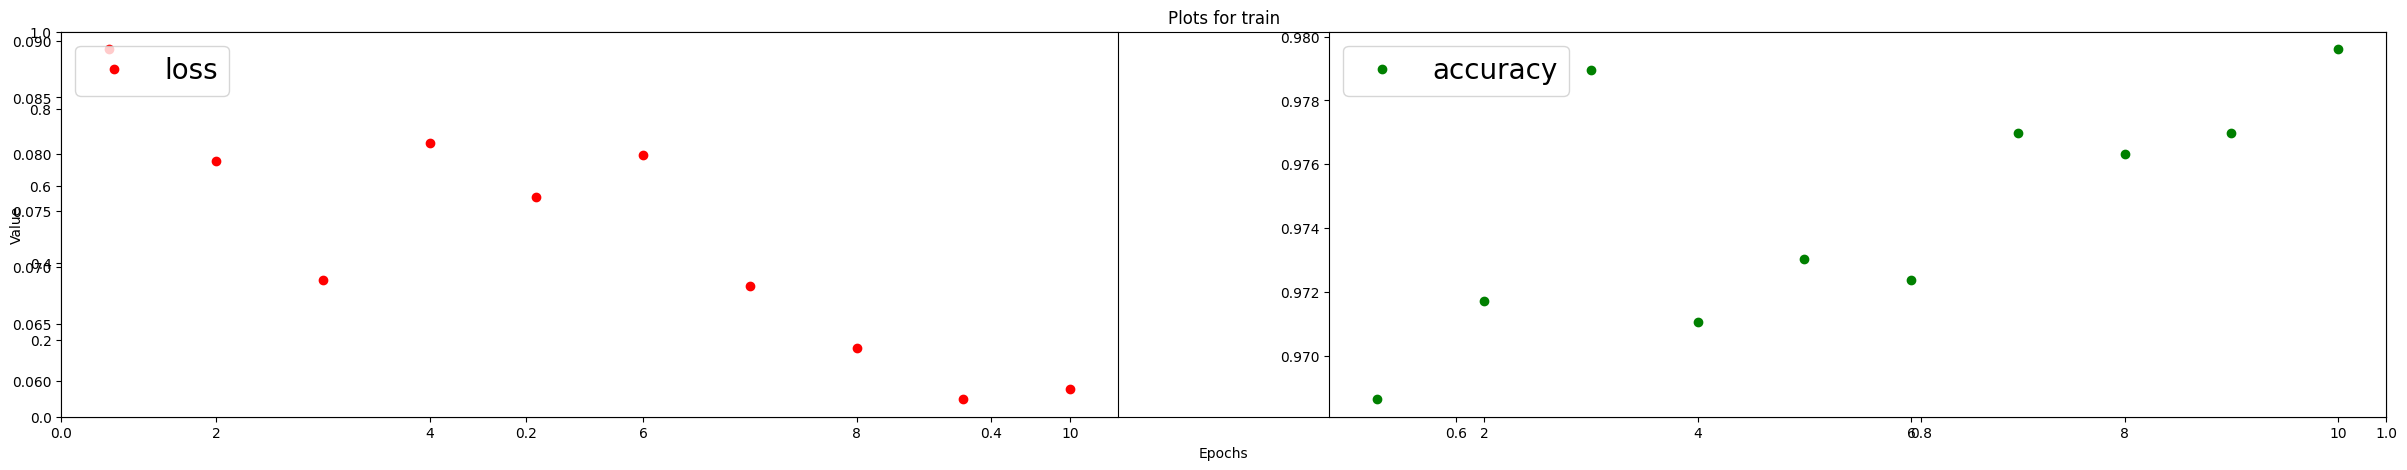

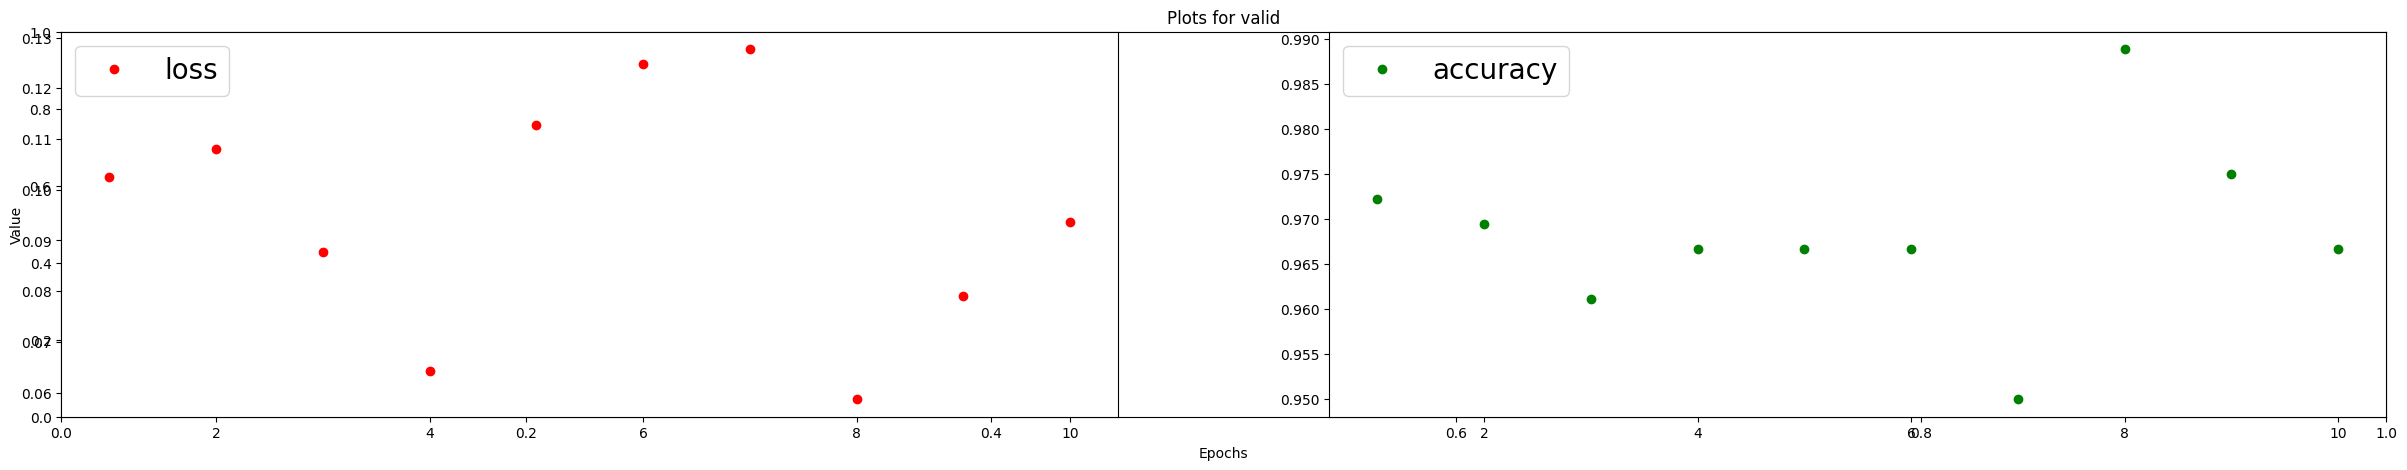

In [131]:
print('Learning rate: 0.0007, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=20, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.001, Batch size: 50
Epoch : 1, train accuracy : 0.9722576141357422, train loss : 0.08083857595920563
Epoch : 1, val_accuracy : 0.9749999642372131, val_loss : 0.08111375570297241
Epoch : 2, train accuracy : 0.980644702911377, train loss : 0.05518154799938202
Epoch : 2, val_accuracy : 0.9850000143051147, val_loss : 0.07513797283172607
Epoch : 3, train accuracy : 0.980644702911377, train loss : 0.0595797598361969
Epoch : 3, val_accuracy : 0.9511110782623291, val_loss : 0.14646878838539124
Epoch : 4, train accuracy : 0.9746232032775879, train loss : 0.07148367166519165
Epoch : 4, val_accuracy : 0.976111114025116, val_loss : 0.0468769408762455
Epoch : 5, train accuracy : 0.973440408706665, train loss : 0.07574688643217087
Epoch : 5, val_accuracy : 0.9699999690055847, val_loss : 0.07504212856292725
Epoch : 6, train accuracy : 0.9787092208862305, train loss : 0.06239154562354088
Epoch : 6, val_accuracy : 0.9711111187934875, val_loss : 0.11793462932109833
Epoch : 7, train accu

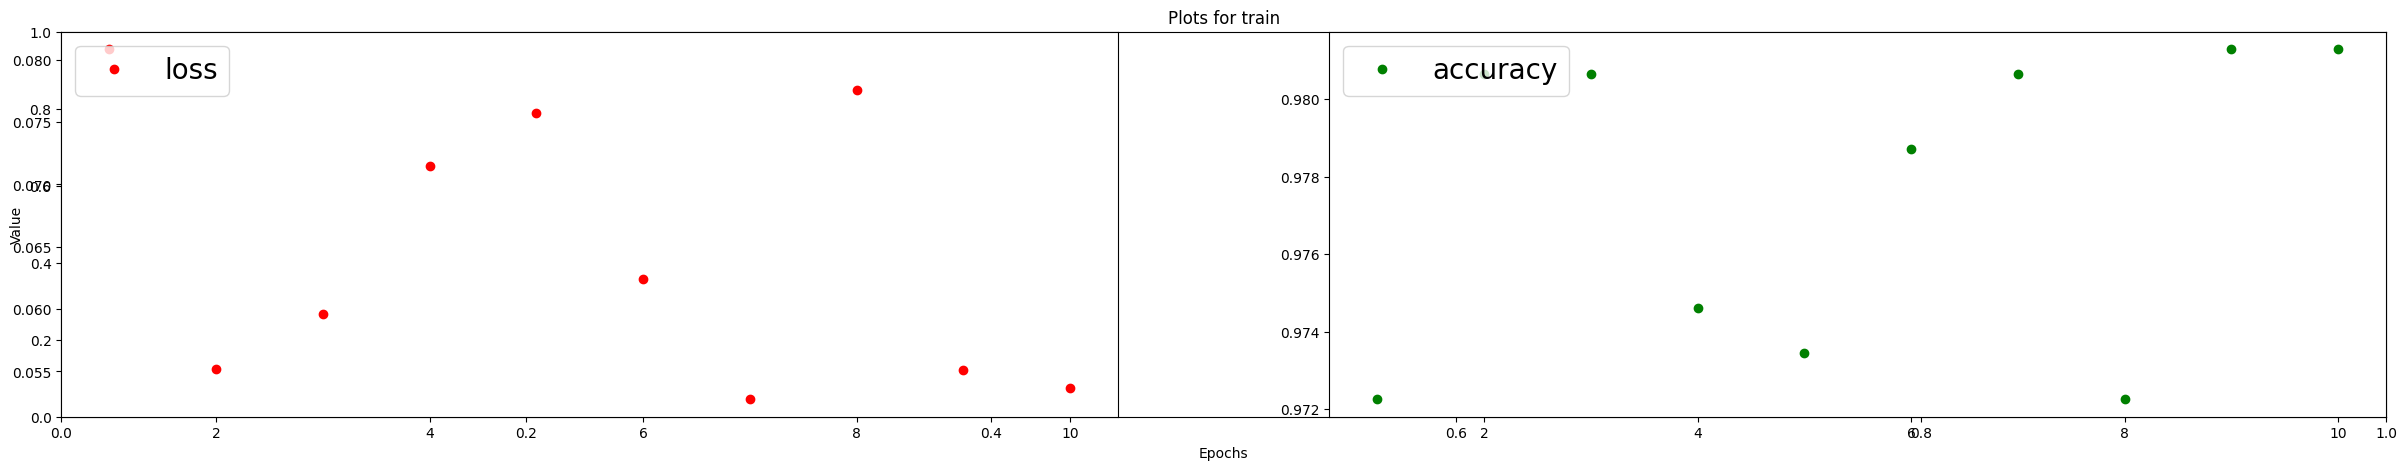

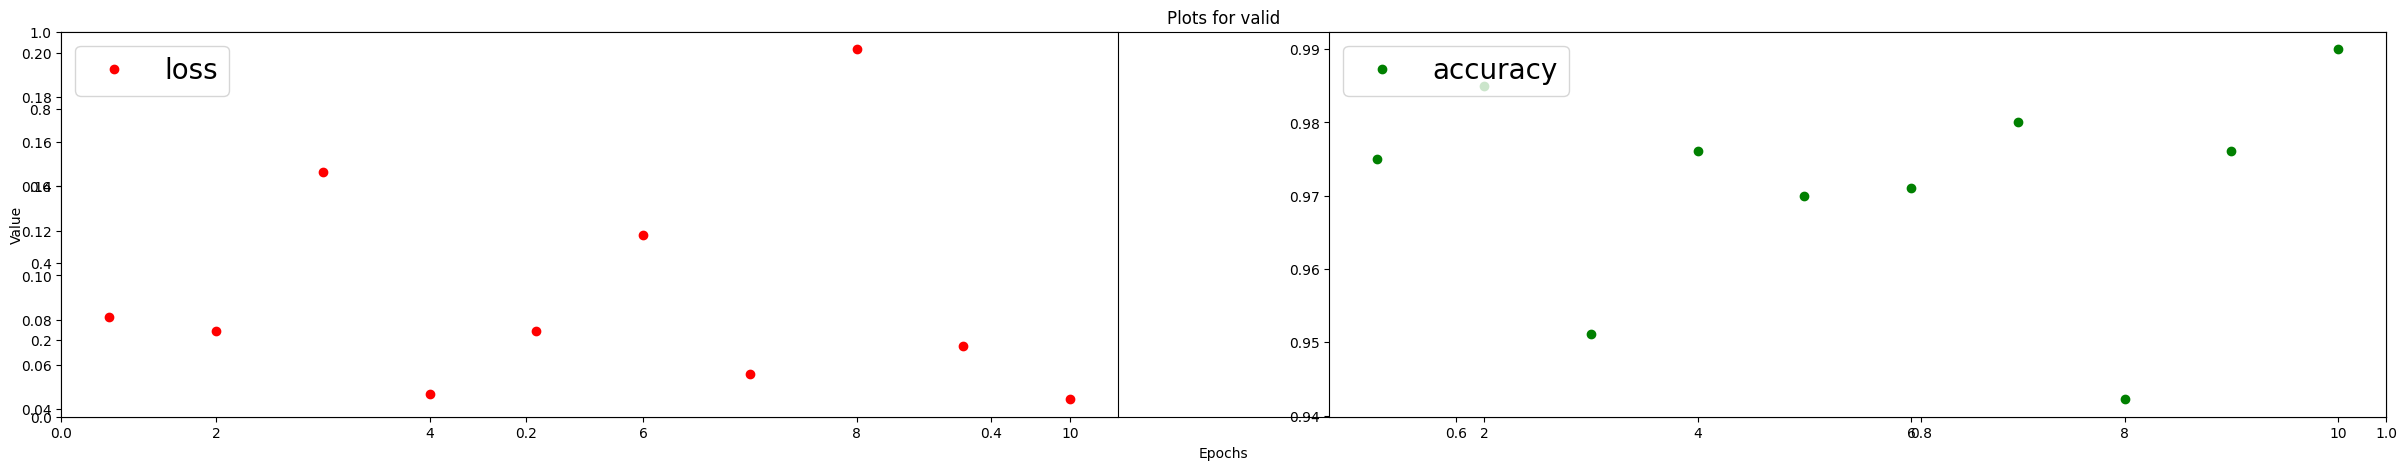

In [132]:
print('Learning rate: 0.001, Batch size: 50')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=50, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=50, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0005, Batch size: 50
Epoch : 1, train accuracy : 0.9754834175109863, train loss : 0.06567155569791794
Epoch : 1, val_accuracy : 0.9749999642372131, val_loss : 0.0726667046546936
Epoch : 2, train accuracy : 0.9819350242614746, train loss : 0.05332498997449875
Epoch : 2, val_accuracy : 0.9572221636772156, val_loss : 0.08122703433036804
Epoch : 3, train accuracy : 0.9851608276367188, train loss : 0.04220735281705856
Epoch : 3, val_accuracy : 0.9811111092567444, val_loss : 0.07624887675046921
Epoch : 4, train accuracy : 0.9870963096618652, train loss : 0.04400898888707161
Epoch : 4, val_accuracy : 0.9750000238418579, val_loss : 0.05755321681499481
Epoch : 5, train accuracy : 0.9896769523620605, train loss : 0.03691383823752403
Epoch : 5, val_accuracy : 0.9850000143051147, val_loss : 0.04820321500301361
Epoch : 6, train accuracy : 0.9838705062866211, train loss : 0.04438949376344681
Epoch : 6, val_accuracy : 0.976111114025116, val_loss : 0.1242428869009018
Epoch : 7, train 

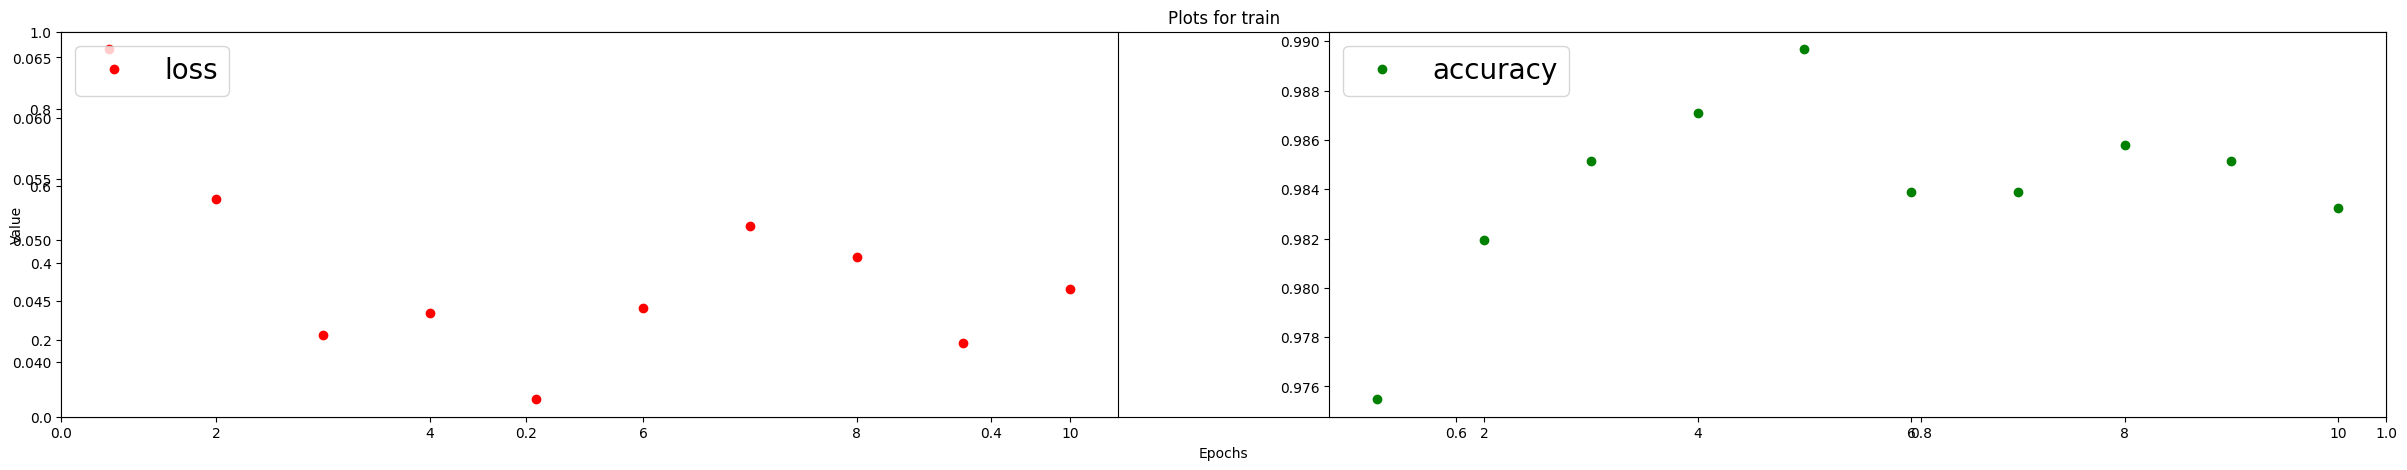

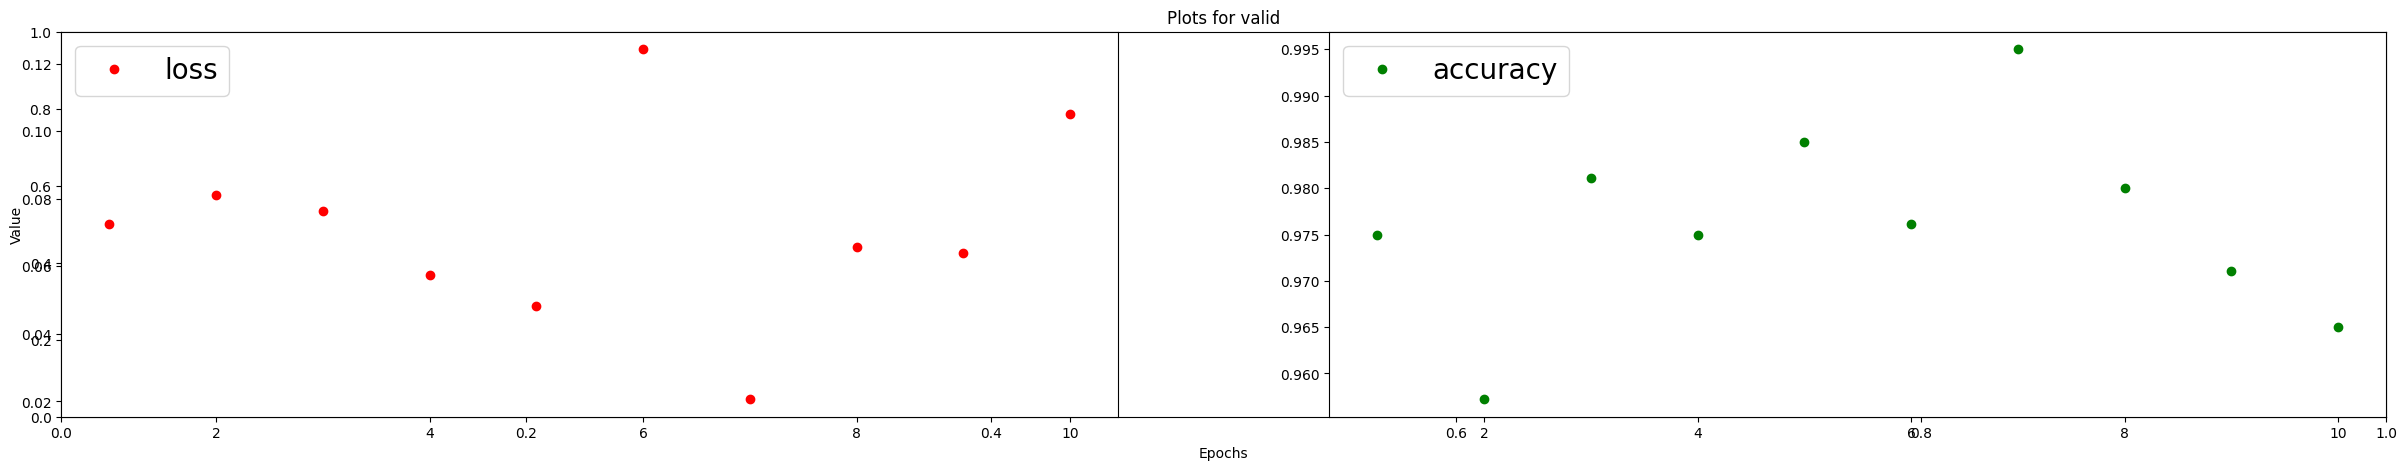

In [133]:
print('Learning rate: 0.0005, Batch size: 50')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=50, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=50, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 50
Epoch : 1, train accuracy : 0.9819350242614746, train loss : 0.055169641971588135
Epoch : 1, val_accuracy : 0.9661110639572144, val_loss : 0.08665183931589127
Epoch : 2, train accuracy : 0.9777414798736572, train loss : 0.07430531084537506
Epoch : 2, val_accuracy : 0.9749999642372131, val_loss : 0.06589265167713165
Epoch : 3, train accuracy : 0.981719970703125, train loss : 0.04783827066421509
Epoch : 3, val_accuracy : 0.9661111235618591, val_loss : 0.0857606902718544
Epoch : 4, train accuracy : 0.977311372756958, train loss : 0.05879439786076546
Epoch : 4, val_accuracy : 0.9611110687255859, val_loss : 0.08584051579236984
Epoch : 5, train accuracy : 0.9838705062866211, train loss : 0.054257191717624664
Epoch : 5, val_accuracy : 0.9811111092567444, val_loss : 0.03698284924030304
Epoch : 6, train accuracy : 0.9812898635864258, train loss : 0.056730788201093674
Epoch : 6, val_accuracy : 0.9900000095367432, val_loss : 0.06315289437770844
Epoch : 7, tra

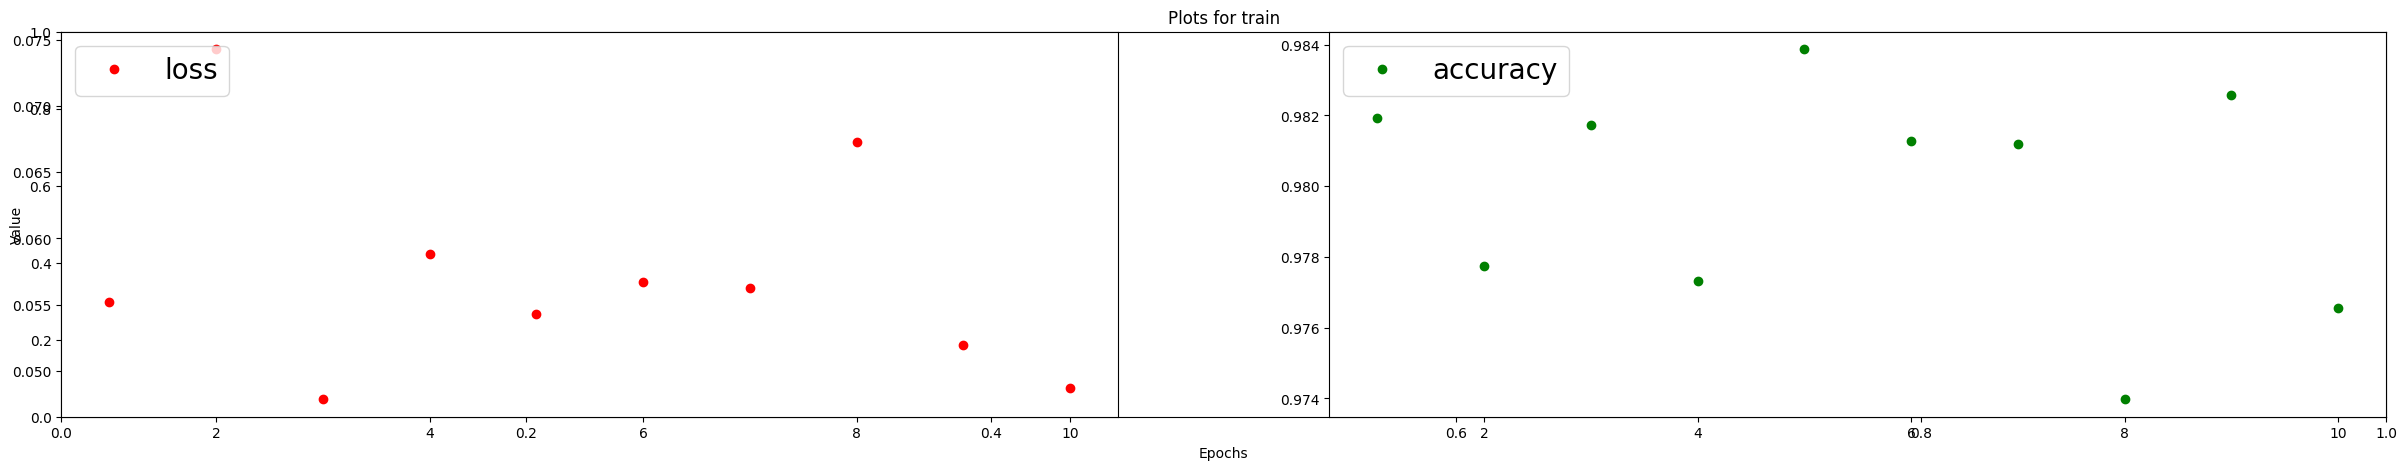

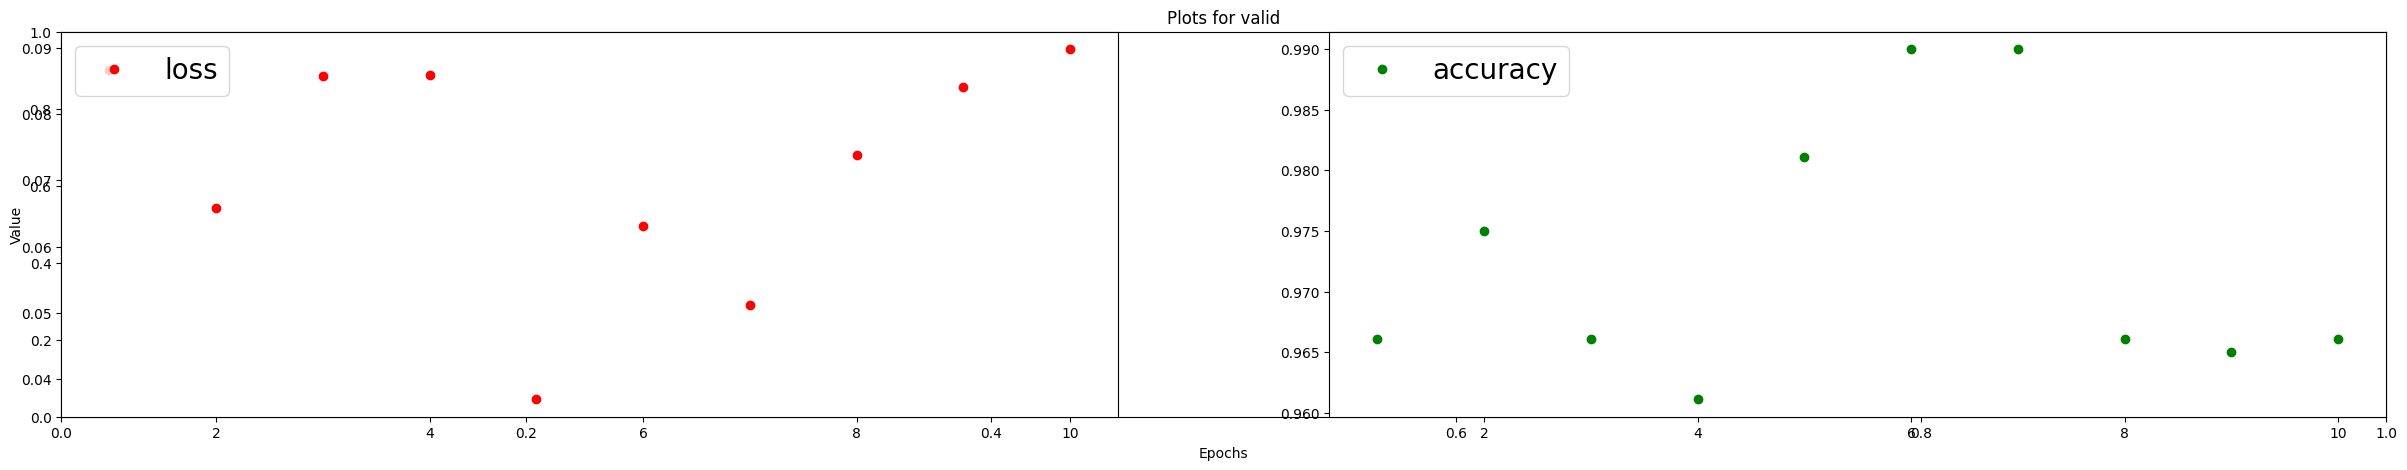

In [134]:
print('Learning rate: 0.0007, Batch size: 50')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=50, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=50, shuffle=True)

train_loop(train_loader, val_loader, epochs)

7-8. Работа модели.

In [168]:
polarbears_probs = []
model.eval()
i = 1
with torch.no_grad():
    for images, labels in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        polarbears_probs += list(zip(labels, preds_list))
        
idx = list(map(lambda x: x[0],polarbears_probs))
prob = list(map(lambda x: x[1],polarbears_probs))

submission = pd.DataFrame({'id':idx,'label':prob})

submission

,id,label
0,36,0.982158
1,143,0.001897
2,140,0.011531
3,87,0.002970
4,82,0.014562
...,...,...
205,98,0.032499
206,74,0.994515
207,15,0.309596
208,88,0.992619


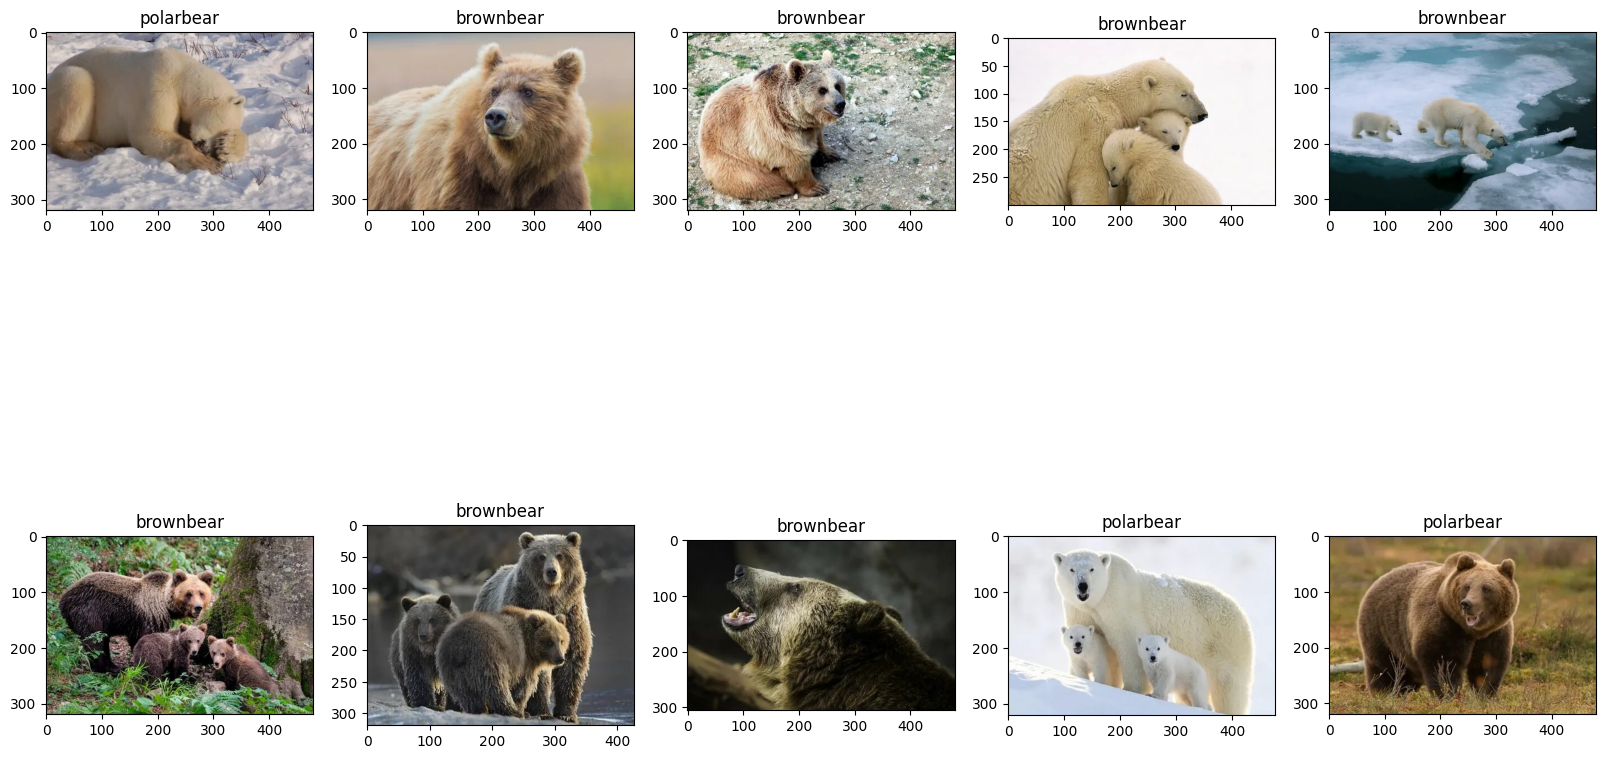

In [169]:

id_list = []
class_ = {0: 'brownbear', 1: 'polarbear'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(test_path, f'{i}.jpg')
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)